## Exemple de modélisation

Ce notebook contient un premier modèle relativement complet de modélisation des données climatiques par un MLP.

Il y a 3 étapes principales dans le processus de modélisation :
1. le chargement des données au travers d'un [`Dataset`](https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.Dataset),
2. l'architecture du modèle de deep learning avec les objets du module [`nn`](https://docs.pytorch.org/docs/stable/nn.html),
3. la boucle d'apprentissage en 3 phases.

In [1]:
!curl -sSL -q -o - "https://cloud.minesparis.psl.eu/index.php/s/MGp21fRa8LEzO3f/download?path=%2F&files=mig25_data.tgz" | tar -xzv

data/
data/TA_1d.csv
data/TP_1d.csv
data/CF_1d.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch

sns.set_style('whitegrid')

### 1. Dataset & Dataloader

In [3]:
from torch.utils.data import Dataset

class HydroDataset(Dataset):
    def __init__(self):
        # Charger les données depuis Pandas
        cf = pd.read_csv("data/CF_1d.csv", index_col="Date", parse_dates=["Date"])
        ta = pd.read_csv("data/TA_1d.csv", index_col="Date", parse_dates=["Date"])
        tp = pd.read_csv("data/TP_1d.csv", index_col="Date", parse_dates=["Date"])

        # Sélectionner les colonnes en rapport avec la France
        cf = cf[["FR"]]
        ta = ta.loc[:, ta.columns.str.startswith("FR")]
        tp = tp.loc[:, tp.columns.str.startswith("FR")]

        # Assembler les 3 dataframes dans un unique dataframe
        df = pd.concat([ta, tp, cf["FR"].rename("CF")], axis=1)
        df.index = df.index.astype("datetime64[s]")
        self.df = df  # au cas où nous en aurions besoin plus tard

        # Créer les variables self.X, self.y et self.ts
        self.X = torch.from_numpy(df.drop(columns="CF").to_numpy().astype("float32"))
        self.y = torch.from_numpy(df["CF"].to_numpy().astype("float32"))
        self.ts = torch.from_numpy(df.index.to_numpy().astype("int32"))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.ts[idx]

In [4]:
from torch.utils.data import Subset

ds = HydroDataset()

train_ds = Subset(ds, np.flatnonzero(ds.df.index.year < 2022))
valid_ds = Subset(ds, np.flatnonzero(ds.df.index.year == 2022))
test_ds = Subset(ds, np.flatnonzero(ds.df.index.year == 2023))

# pour accéder aux données du sous-ensemble :
# train_ds.dataset[train_ds.indices]

### 2. Modèle de deep learning

In [5]:
import torch.nn as nn

class HydroModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_features=42, out_features=16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=16, out_features=1),
            nn.ReLU()
        )

    def forward(self, x):
        y = self.mlp(x)
        return y.squeeze()

### 3. Boucle d'entrainement

In [6]:
from torch.nn import MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader

torch.manual_seed(42)

# ⚙️ Hyperparamètres
LR = 1e-4
BATCHSIZE = 64
EPOCHS = 20

# 🧩 Initialisation des composants
model = HydroModel()
criterion = MSELoss(reduction='sum')
optimizer = Adam(params=model.parameters(), lr=LR)

# Paramètres pour la normalisation
X, *_ = train_ds.dataset[train_ds.indices]
mu, sigma = X.mean(dim=0), X.std(dim=0)  # ⚠️ calculés que le sur le train !!!

# 💼 Gestionnaire de batchs
train_loader = DataLoader(train_ds, batch_size=BATCHSIZE, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=BATCHSIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCHSIZE, shuffle=False)

train_history = []

for epoch in range(EPOCHS):
    print(f"[Epoch {epoch}]")

    ### 🧠 Training step ###
    model.train()
    train_loss = 0.

    for batch in train_loader:
        X, y, ts = batch  # récupération des tenseurs
        X = (X - mu) / sigma  # application de la normalisation

        # apprentissage / optimisation
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()

        # 📉 perte du batch courant
        train_loss += loss.item()

    # 📈 perte de l'epoch courante
    train_loss /= len(train_loader.dataset)
    print(f"Training loss: {train_loss}")

    ### 🎯 Validation step ###
    model.eval()
    valid_loss = 0.

    with torch.no_grad():
        for batch in valid_loader:
            X, y, ts = batch  # récupération des tenseurs
            X = (X - mu) / sigma  # application de la normalisation

            y_hat = model(X)
            loss = criterion(y_hat, y)

            # 📉 perte du batch courant
            valid_loss += loss.item()

    # 📈 perte de l'epoch courante
    valid_loss /= len(valid_loader.dataset)
    print(f"Valid loss: {valid_loss}")
    print()

    train_history.append([epoch, train_loss, valid_loss])

### 🔮 Testing step ###
model.eval()
test_loss = 0.

out = []
with torch.no_grad():
    for batch in test_loader:
        X, y, ts = batch  # récupération des tenseurs
        X = (X - mu) / sigma  # application de la normalisation

        y_hat = model(X)
        loss = criterion(y_hat, y)

        # 📉 perte du batch courant
        test_loss += loss.item()

        # 📊 enregistrement des résultats pour exploitation
        out.append(np.stack([y_hat.numpy(), y.numpy(), ts.numpy()], axis=1))

# 📈 perte moyenne sur le jeu de test
test_loss /= len(test_loader.dataset)
print(f"Testing loss: {test_loss}")
print()

[Epoch 0]
Training loss: 0.10178635274360791
Valid loss: 0.04659462628299243

[Epoch 1]
Training loss: 0.09377367949065864
Valid loss: 0.0413545500742246

[Epoch 2]
Training loss: 0.08559047051371893
Valid loss: 0.027238297789064173

[Epoch 3]
Training loss: 0.06478115901088528
Valid loss: 0.022944193343593648

[Epoch 4]
Training loss: 0.0564915769954017
Valid loss: 0.026495247017847348

[Epoch 5]
Training loss: 0.05452779445162958
Valid loss: 0.02622320390727422

[Epoch 6]
Training loss: 0.053382080641744656
Valid loss: 0.026050556522526153

[Epoch 7]
Training loss: 0.05024820363218304
Valid loss: 0.02684188085059597

[Epoch 8]
Training loss: 0.04840762993127633
Valid loss: 0.02435560781661778

[Epoch 9]
Training loss: 0.04729470488143294
Valid loss: 0.02424600908201035

[Epoch 10]
Training loss: 0.04612994576620263
Valid loss: 0.023892528716831993

[Epoch 11]
Training loss: 0.04375073536501472
Valid loss: 0.022786304722093555

[Epoch 12]
Training loss: 0.04200402953153487
Valid loss:

### 4. Exploitation des résultats

Comme pour le ML, nous reprenons le code d'affichage des résultats :

In [ ]:
def display_result(y_true, y_pred):
    """Affiche les résultats de prédiction / réels."""
    fig = plt.figure(figsize=(16, 4), constrained_layout=True)
    gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[2, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])

    # Plot 1
    ax1.set_title("Capacity factor predictions")
    ax1.plot(y_true.index, y_true, color="tab:blue", label="Actual")
    ax1.plot(y_true.index, y_pred, color="tab:red", label="Predicted")

    ax1.set_xlim(y_true.index[0], y_true.index[-1])
    ax1.legend(loc="lower right", title="Capacity Factor")

    # Plot 2
    ax2.set_title("Actual vs Predicted")
    ax2.set_xlabel("Actual")
    ax2.set_ylabel("Predicted")
    ax2.scatter(y_true, y_pred, color="tab:blue", s=10)

    left, right = ax2.get_xlim()
    bottom, top = ax2.get_ylim()
    lb = min(left, bottom) - 0.01
    ub = max(right, top) + 0.01
    ax2.set_ylim(lb, ub)
    ax2.set_xlim(lb, ub)
    ax2.axline((lb, lb), (ub, ub), color="tab:red")

    plt.show()

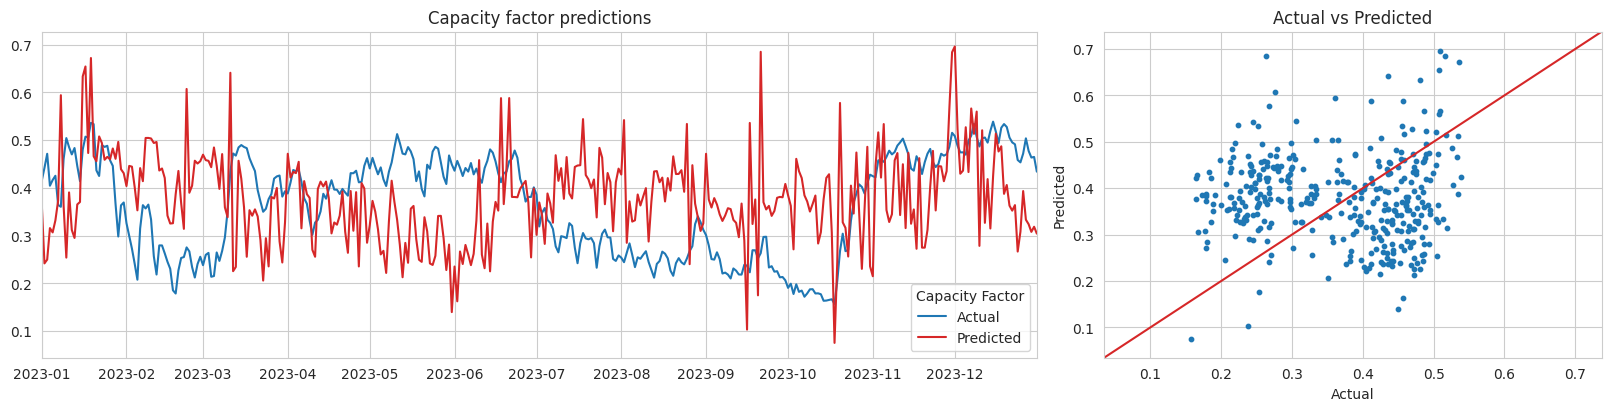

In [ ]:
df = pd.DataFrame(np.concatenate(out), columns=["Predicted", "Actual", "DateTime"])
df["DateTime"] = pd.to_datetime(df["DateTime"], unit="s")
df = df.set_index("DateTime")
display_result(df["Actual"], df["Predicted"])

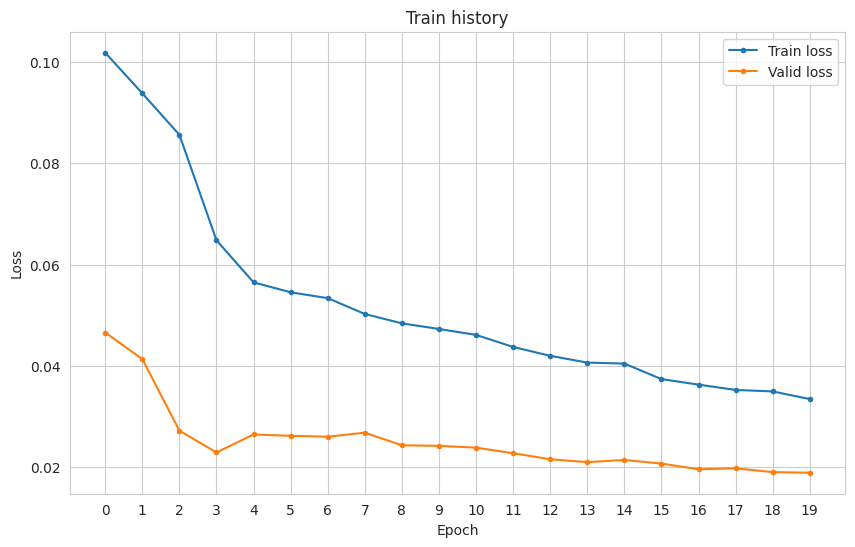

In [ ]:
hist = pd.DataFrame(train_history, columns=["Epoch", "Train", "Valid"]).set_index("Epoch")
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(hist.index, hist["Train"], marker=".", label="Train loss")
ax.plot(hist.index, hist["Valid"], marker=".", label="Valid loss")
ax.xaxis.set_major_locator(mpl.ticker.FixedLocator(hist.index))
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Train history")
plt.legend()
plt.show()